# Host a Boke AI Keras Model on Amazon SageMaker

Amazon SageMaker is a fully-managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The SageMaker Python SDK makes it easy to train and deploy models in Amazon SageMaker with several different machine learning and deep learning frameworks, including TensorFlow and Keras.

In this notebook, we train and host a Keras boke-AI model on SageMaker. The model used for this notebook is a neural network (CNN and Bidirectional-LSTM) for image captioning that was developed by Ryuichi Ishikawa (Dentsu Digital).

<br>

in the `us-west-2`, `us-east-1`, `us-east-2`, and `ap-northeast-1` regions. 

Price per hour depends on your region and instance type. You can reference prices on the [SageMaker pricing page](https://aws.amazon.com/sagemaker/pricing/).  

---
---

In [1]:
!pip install -U sagemaker

import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Setup
First, we define a few variables that are be needed later in the example.

In [ ]:
import os
import json
import boto3

from sagemaker import Session
from sagemaker import get_execution_role

sagemaker_session = Session()
default_bucket = sagemaker_session.default_bucket()
role = get_execution_role()

#　学習済みを利用
preprocessed_bokekan_metadata = 's3://xxx...xxx/output/bokekan_metadata'
model_path = 's3://xxx...xxx/output/model.tar.gz'

## Bokete Bokekan dataset

Bokete is one of the most popular commedy web site. [Bokekan dataset](../README.md) consists of 1M+ images/text pairs to 4 different classes. Here are the classes in the dataset, as well as 1 random image/text pair:

| class | boke (image/text pair) | number of stars |
| ---- | ----: | ---- |
| blue | 98,736 | 0 |
| yellow | 955,901 | 1 - 100 |
| green | 37,342 | 101 - 1000 |
| red | 8,183 | 1001 - 10000 |
| sp | 380 | 10001+ |
| Total | 1,100,542 | boke |

<div align="center"><img src="https://d1.awsstatic.com/Developer%20Marketing/jp/magazine/2020/img_bokete_01.a9c39e30940cf3c6fb5ba795b9202a57a843da05.jpg" alt="bokete" width="320"/></div>
<div align="center">(Photo by IHA Central Office, licensed under the Creative Commons Attribution License 2.0)</div>


Here, you will copy the Bokekan dataset to your SageMaker default bucket. 

## Deploy the trained model

After we train our model, we can deploy it to a SageMaker Endpoint, which serves prediction requests in real-time. To do so, we simply call `deploy()` on our estimator, passing in the desired number of instances and instance type for the endpoint.

Because we're using TensorFlow Serving for deployment, our training script saves the model in TensorFlow's SavedModel format.  

We don't need accelerated computing power for inference, so let's switch over to a <b>ml.m4.xlarge</b> instance type. 

For more information about deploying Keras and TensorFlow models in SageMaker, see [this blog post](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker).

In [ ]:
# retrieve parameters
!aws s3 cp {preprocessed_bokekan_metadata}/param.json ./

with open('./param.json') as json_file:
    param = json.load(json_file)
    print(param)

max_word = param['max_word']
vocabulary_size = param['vocabulary_size']

In [ ]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=model_path,
    role=role,
    framework_version='2.3'
    )

predictor = model.deploy(initial_instance_count=1, instance_type='local')


### Invoke the endpoint

To verify the that the endpoint is in service, we generate some random data in the correct shape and get a prediction.

In [4]:
!pip install matplotlib

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import reshape, stack, convert_to_tensor

Now let's use the test dataset for predictions. We will setup for inference preprocessing. 

In [6]:
from tensorflow.keras.models              import Model
from tensorflow.keras.applications.vgg16  import VGG16 

VGG = VGG16(weights='imagenet')
VGG._layers.pop()
VGG = Model(inputs=VGG.inputs, outputs=VGG.layers[-1].output)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 852, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 914, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 857, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmp2l3sztzh/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Pr

In [7]:
# load dictionary
id_word = pd.read_csv(os.path.join(preprocessed_bokekan_metadata, 'id_word_bokete_data.csv'), index_col=0).to_dict()['1']

In [8]:
# sample the first word from a distribution
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float32")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probs = np.random.multinomial(1, preds, 1)
    return np.argmax(probs)

You can find your favorite image from https://bokete.jp/boke/select, then copy&paste the image url. 

In [9]:
image_url = 'https://d2dcan0armyq93.cloudfront.net/photo/odai/600/2182ab815bdb2abae3b67e723861ac08_600.jpg'
# image_url = 'https://d2dcan0armyq93.cloudfront.net/photo/odai/600/0235436e0d5d54c882f485e367f68fe6_600.jpg'
# image_url = 'https://d2dcan0armyq93.cloudfront.net/photo/odai/600/db6e0eb2dd26330e1884d0812d78e783_600.jpg'

!wget {image_url} ./
image_path = image_url.split('/')[-1]

--2022-05-30 11:35:49--  https://d2dcan0armyq93.cloudfront.net/photo/odai/600/2182ab815bdb2abae3b67e723861ac08_600.jpg
Resolving d2dcan0armyq93.cloudfront.net (d2dcan0armyq93.cloudfront.net)... 99.84.71.58, 99.84.71.22, 99.84.71.170, ...
Connecting to d2dcan0armyq93.cloudfront.net (d2dcan0armyq93.cloudfront.net)|99.84.71.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56837 (56K) [image/jpeg]
Saving to: ‘2182ab815bdb2abae3b67e723861ac08_600.jpg.1’

2182ab815bdb2abae3b 100%[===================>]  55.50K  --.-KB/s    in 0.006s  

2022-05-30 11:35:49 (8.45 MB/s) - ‘2182ab815bdb2abae3b67e723861ac08_600.jpg.1’ saved [56837/56837]

--2022-05-30 11:35:49--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-05-30 11:35:49--
Total wall clock time: 0.05s
Downloaded: 1 files, 56K in 0.006s (8.45 MB/s)


In [10]:
# Preprocess test image array
img = load_img(image_path, target_size=(224, 224))
x = np.array(img)/255

x = VGG(reshape(x, [1, 224, 224, 3]))
X_test_image = np.array(x)

# Prepare empty text array
x2 = np.zeros([1, max_word])
x2[0, -1] = 1. # set {1: 'Beginning Of Sentence (BOS)'} at the beginning 
X_test_text = np.array(x2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



With the data loaded, we can use it for predictions:

In [11]:
%%time

max_length = max_word
for i in range(max_length):
    payload = {"inputs": {"image": X_test_image.tolist(), "text": X_test_text.tolist()}}
    outputs = np.array(predictor.predict(payload)['outputs'])

    # sampling the initial word
    if i == 0:
        X_test_text = np.append(X_test_text, sample(outputs[0], 1.0))[1:].reshape(1,-1)

    elif outputs.argmax() == 0:
        break

    else:
        X_test_text = np.append(X_test_text, outputs.argmax())[1:].reshape(1,-1)

CPU times: user 248 ms, sys: 534 ms, total: 782 ms
Wall time: 3.42 s


With the predictions, we calculate our model accuracy and create a confusion matrix.

工ロDVDの「お父さん、これは裏返ると自力でこねようと思いますが、鼓膜パースの話は日常茶飯事」


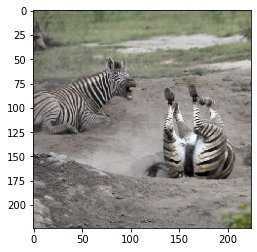

In [12]:
from operator import itemgetter
boke = ''.join(itemgetter(*X_test_text[0].tolist())(id_word)).split('BOS')[-1]

plt.imshow(img)
print(boke) 

Aided by the colors of the heatmap, we can use this confusion matrix to understand how well the model performed for each label.print